In [1]:
#-*- coding: utf-8 -*-

<img align="right" style="max-width: 200px; height: auto" src="cfds_logo.png">

###  Lab 05 - "Unsupervised Machine Learning"

Chartered Financial Data Scientist (CFDS), Autumn Term 2019/20

In the last lab you learned about how to utilize two **supervised** learning classification techniques namely (1) the Gaussian Naive-Bayes (Gaussian NB) classifier and (2) the k Nearest-Neighbor (kNN) classifier. 

In this fourth lab we will learn about an **unsupervised** machine learning technique referred to as **k-Means Clustering**. We will use this technique to classify un-labelled data (i.e., data without defined categories or groups). In general, clustering-based techniques are widely used in unsupervised machine learning.

The **k-Means Clustering** algorithm is one of the most popular clustering algorithms used in machine learning. The goal of k-Means Clustering is to find groups (clusters) in a given dataset. It can be used (1) to **confirm business assumptions** about what types of groups exist or (2) to **identify unknown groups** in complex data sets. Some examples of business-related use cases are:

>- Segment customers by purchase history;
>- Segment users by activities on an application or a website;
>- Group inventory by sales activity; or,
>- Group inventory by manufacturing metrics.

(Source: https://www.datascience.com/blog/k-means-clustering)

Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the correct group.

As always, pls. don't hesitate to ask all your questions either during the lab or send us an email via marco.schreyer@fds.ai or damian.borth@fds.ai.

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand how a **k-Means Clustering** algorithm can be trained and evaluated.
> 2. Know how to Python's **sklearn library** to train and evaluate arbitrary classifiers.
> 3. Understand how to evaluate the **classification results** of the k-Means algorithm.
> 4. Know how to select an **optimal number of clusters** or cluster means.

### Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will be using pandas, numpy, sklearn, matplotlib and seaborn library to conduct this:

In [1]:
# import the pandas data science library
import pandas as pd
import numpy as np

# import sklearn data and data pre-processing libraries
from sklearn import datasets

# import sklearn k-means classifier library
from sklearn.cluster import KMeans

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

Create nice looking plots using the **seaborn** plotting theme:

In [2]:
plt.style.use('seaborn')

Enable inline Jupyter notebook plotting:

In [3]:
%matplotlib inline

Suppress potential warnings:

In [4]:
import warnings
warnings.filterwarnings('ignore')

Set random seed of all our experiments:

In [1]:
random_seed = 42

## Unsupervised Machine Learning: k-Means Clustering

### 1.1: Dataset Download and Data Assessment

The iris dataset is a classic and very easy multi-class classification dataset. This dataset consists of 3 different types of irises’ (classes),  namely Setosa, Versicolour, and Virginica) as well as their respective petal and sepal length (features). In total, the dataset consists of **150 samples** (50 samples per class) as well as their corresponding **4 different measurements** taken for each sample. 

<img align="center" style="max-width: 700px; height: auto" src="iris_dataset.png">

(Source: http://www.lac.inpe.br/~rafael.santos/Docs/R/CAP394/WholeStory-Iris.html)

Please, find below the list of the individual measurements (features):

>- `Sepal length (cm)`
>- `Sepal width (cm)`
>- `Petal length (cm)`
>- `Petal width (cm)`

Further details on the dataset can be obtained from the following publication: *Fisher, R.A. "The use of multiple measurements in taxonomic problems" Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to Mathematical Statistics" (John Wiley, NY, 1950)."*

Let's load the dataset and conduct a preliminary data assessment: 

In [5]:
iris = datasets.load_iris()

Print and inspect feature names of the dataset:

In [6]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Print and inspect the class names of the dataset:

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Print and inspect the top 5 feature rows of the dataset:

In [8]:
pd.DataFrame(iris.data).head(5)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Print and inspect the top 5 labels of the dataset:

In [9]:
pd.DataFrame(iris.target).head(5)

,0
0,0
1,0
2,0
3,0
4,0


Determine and print the feature dimensionality of the dataset:

In [10]:
iris.data.shape

(150, 4)

Determine and print the label dimensionality of the dataset:

In [11]:
iris.target.shape

(150,)

Let's briefly envision how the feature data is collected and recorded in the data:

<img align="center" style="max-width: 900px; height: auto" src="featurecollection.png">

Plot the data distributions of the distinct features:

<Figure size 720x720 with 0 Axes>

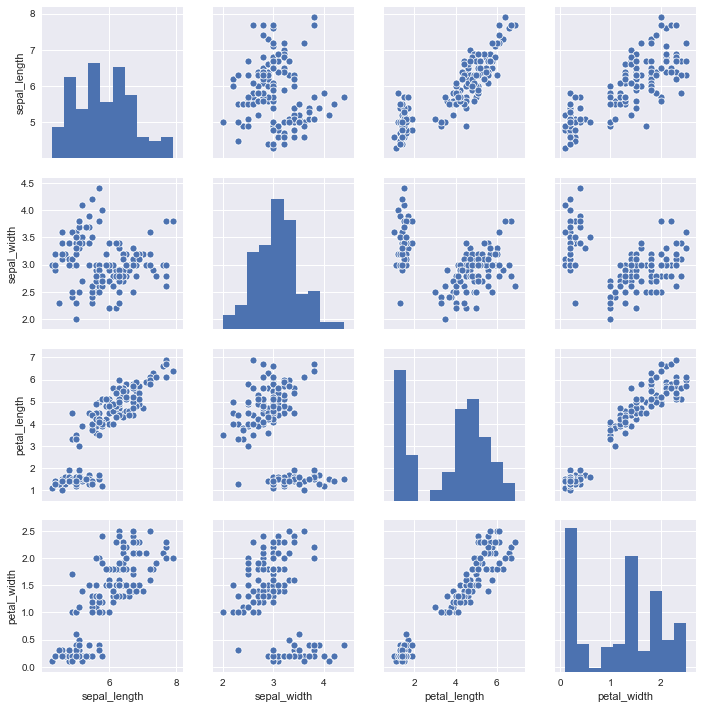

In [12]:
plt.figure(figsize=(10, 10))
iris_plot = sns.load_dataset("iris")

# supervised scenario
#sns.pairplot(iris_plot, diag_kind='hist', hue='species');

# unsupervised scenario
sns.pairplot(iris_plot, diag_kind='hist');

### 1.2. k-Means Clustering Introduction

As already mentioned the **k-Means Clustering** algorithm is one of the most popular "first choice" clustering algorithms to find groups (clusters) in a given dataset $X$. Let's now briefly revisit the distinct step of the algorithm before applying it to the iris dataset. 

<img align="center" style="max-width: 400px; height: auto" src="kmeans.png">

But before that let's assume:

- We have dataset $X$ consisting records $x_1, x_2, x_3, ..., x_n \in \mathcal{R}^d$; 
- That samples are clustered around $k$ centers (the "$k$ means") denoted by $\mu_1, \mu_{2}, ..., \mu_{k} \in \mathcal{R}^d$; and,
- Each sample $x_{i}$ belongs to its closest mean $\mu_{i}$.

We can then iteratively perform the following steps that comprise the **k-Means Clustering** algorithm:

>- **Step 1** - Pick $k$ random points $\mu_{i}$ as cluster centres called 'means'.
>- **Step 2** - Assign each $x_i$ to its to nearest cluster mean by calculating its distance to each mean.
>- **Step 3** - Determine the new cluster centres by calculating the average of the assigned points in each cluster.
>- **Step 4** - Repeat Step 2 and 3 until none of the cluster assignments change.

Note, that a single execution of all the four steps outlined above is usually referred to as 'iteration'.

### 1.3 k-Means Clustering in a 2-Dimensional Feature Space

Now, let's see how we can apply it to the iris dataset. We will start with an introductory example of detecting the classes of the iris dataset based on two of its features namely the (1) `Petal length (cm)` and `Petal width (cm)`. Let's first gain an intuition of those two features as well as their distribution by visualizing them accordingly:

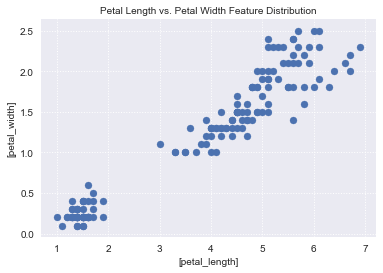

In [13]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.scatter(iris.data[:,2], iris.data[:,3])

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=10)
ax.set_ylabel("[petal_width]", fontsize=10)

# add plot title
plt.title('Petal Length vs. Petal Width Feature Distribution', fontsize=10);

Let's now define the parameters of the k-Means Clustering. We will start by specifying the number of clusters we aim to detect in the dataset:

In [14]:
no_clusters = 3

Next, we need to define a corresponding number (in our case 3) random cluster centers or 'means' that will be used in the first iteration of the algorithm:

In [15]:
random_means = np.array([[1.0, 3.0], [2.0, 6.0], [1.0, 7.0]])

Finally, we will define a maximum number of iterations that we want to run the **k-Means Clustering** algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound:

In [16]:
max_iterations = 10

Now, we ready to initialize the **k-Means Clustering** algorithm using Python's `sklearn` library of data science algorithms:

In [17]:
kmeans = KMeans(n_clusters=no_clusters, init=random_means, max_iter=max_iterations)

Train the k-Mains classifier and learn a model of the `Petal length (cm)` and  `Petal width (cm)` features in the iris dataset:

In [18]:
kmeans.fit(iris.data[:,2:4])

KMeans(algorithm='auto', copy_x=True,
       init=array([[1., 3.],
       [2., 6.],
       [1., 7.]]), max_iter=10,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Now that we have learned a model of the data, let's inspect the distinct cluster labels that have been assigned to the records of the iris dataset: 

In [19]:
labels = kmeans.labels_
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1]


Furthermore, we want to inspect the coordinates of the cluster centroids assigned by the algorithm:

In [20]:
centers = kmeans.cluster_centers_
print(centers)

[[1.462      0.246     ]
 [5.63777778 2.06      ]
 [4.30727273 1.36181818]]


Let's plot the iris dataset records now using the two features `Petal length (cm)`, `Petal width (cm)` and `Petal length (cm)`, their corresponding learned labels as well as the centroids determined by the **k-Means Clustering** algorithm:

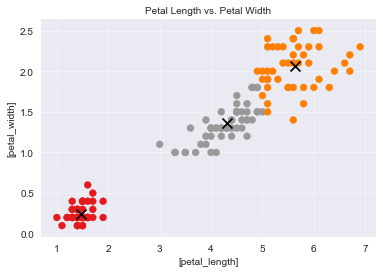

In [21]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
ax.scatter(iris.data[:,2], iris.data[:,3], c=labels.astype(np.float), cmap=plt.cm.Set1)

# plot cluster centers
ax.scatter(centers[:,0], centers[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=10)
ax.set_ylabel("[petal_width]", fontsize=10)

# add plot title
plt.title('Petal Length vs. Petal Width', fontsize=10);

In addition, let's inspect the distance of all dataset records $X$ to their nearest means $\mu_{i}$. Let's recall that k-Means corresponds to a local optimization of the sum of "squared errors", as expressed by:


$$E(\mu_{1}, \mu_{2}, ..., \mu_{k}) = \sum_{i=1}^{n}(x_{i}-\mu_{k(i)})^{2},$$

were $x_{i}$ denotes a single observation in the dataset and $\mu_{k(i)}$ its closest mean in the feature space $\mathcal{R}^{d}$.

We can obtain the sum of those squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ by calling the `inertia_` attribute of the k-Means clustering object. It will return the sum of squared distances of each sample to its closest cluster center:

In [22]:
distances = kmeans.inertia_
print(distances)

31.437981063156826


### Exercises:

We recommend you try the following exercises as part of the lab:

**1. Train and evaluate the k-Means Clustering results and squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ for distinct max iterations.**

> Continuously increase the number of training iterations $i$ of the k-Means Clustering starting with 1 and up to 5 iterations ($i=1,...,5$) and repeat the clustering accordingly. What can be observed in terms of the cluster means as well as the sum of squared cluster distances with increasing $i$.

In [23]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Determine if the k-Mean algorithm always converges to the same results.**

> Carefully review the k-Means algorithm and answer the question and answer to the following question: Does the k-Means algorithm always converge to the same result? Please, explain your reasoning.

In [24]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**3. Applicability k-Means clustering to distinct data distributions.**

> Consider the following data distributions. Determine which are suitable for a k-Means clustering and what $k$ value should be applied in the clustering. Please, explain your reasoning.

<img align="center" style="max-width: 600px; height: auto" src="clustering.png">

In [25]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

### 1.4 k-Means Clustering in a 3-Dimensional Feature Space

Enable interactive 3-dimensional plotting inside of Jupyter notebooks:

In [29]:
%matplotlib notebook
from importlib import reload
reload(plt)

# import the seaborn plotting library
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

We will now extend the k-Means Clustering that you learned about to a 3-dimensional features space by clustering the first three features, namely `Sepal length (cm)`, `Sepal width (cm)` and `Petal length (cm)`, of the Iris dataset. Let's start by visually inspecting the 3-dimensional feature space:

<IPython.core.display.Javascript object>


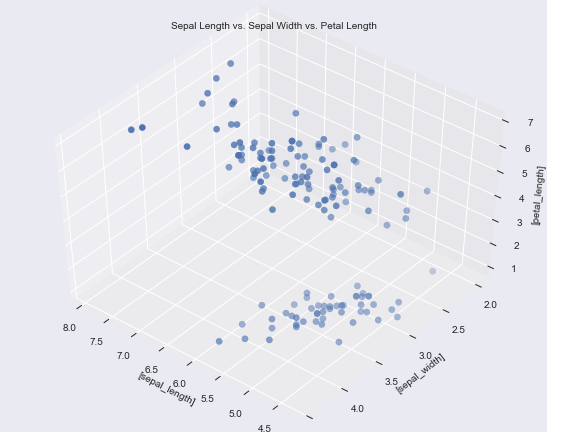

In [30]:
# prepare plot
plt.rcParams['figure.figsize'] = [8, 6]
fig = plt.figure()
ax = fig.add_subplot(111)

# init 3D plotting
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=120)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.scatter(iris.data[:,0], iris.data[:,1], iris.data[:,2], s=40)

# add axis legends
ax.set_xlabel("[sepal_length]", fontsize=10)
ax.set_ylabel("[sepal_width]", fontsize=10)
ax.set_zlabel("[petal_length]", fontsize=10)

# add plot title
plt.title('Sepal Length vs. Sepal Width vs. Petal Length', fontsize=10)

# show the 3-dimensional plot
plt.show();

We will start again by defining a max. number of iterations we aim to run the k-Means algorithm:

In [31]:
max_iterations = 10

Let's also initialize our initial means randomly:

In [32]:
random_means = np.array([[1.0, 3.0, 3.0], [2.0, 6.0, 5.0], [1.0, 7.0, 2.0]])

As well as the k-Means clustering algorithm:

In [33]:
kmeans = KMeans(n_clusters=no_clusters, init=random_means, max_iter=max_iterations)

Let's now fit the 3-dimensional data (instead of the two-dimensional data that we fitted above):

In [34]:
kmeans.fit(iris.data[:,0:3])

KMeans(algorithm='auto', copy_x=True,
       init=array([[1., 3., 3.],
       [2., 6., 5.],
       [1., 7., 2.]]),
       max_iter=10, n_clusters=3, n_init=10, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Let's further inspect the labels:

In [35]:
labels = kmeans.labels_
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


And the learned cluster centers:

In [36]:
centers = kmeans.cluster_centers_
print(centers)

[[5.006      3.428      1.462     ]
 [5.86833333 2.74       4.38166667]
 [6.8525     3.07       5.6925    ]]


Let's plot the iris dataset records now using the three features `Sepal length (cm)`, `Sepal width (cm)` and `Petal length (cm)`, their corresponding learned labels as well as the centroids determined by the **k-Means Clustering** algorithm:

<IPython.core.display.Javascript object>


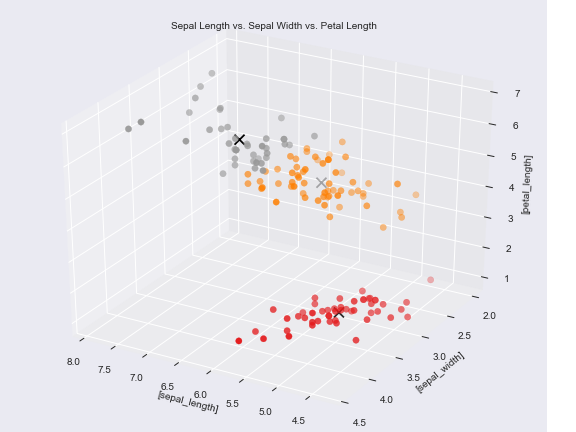

In [37]:
# prepare plot
plt.rcParams['figure.figsize'] = [8, 6]
fig = plt.figure()
ax = fig.add_subplot(111)

# init 3D plotting
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=120)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
ax.scatter(iris.data[:,0], iris.data[:,1], iris.data[:,2], c=labels.astype(np.float), cmap=plt.cm.Set1, s=40)

# plot cluster centers
ax.scatter(centers[:,0], centers[:,1], centers[:,2], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[sepal_length]", fontsize=10)
ax.set_ylabel("[sepal_width]", fontsize=10)
ax.set_zlabel("[petal_length]", fontsize=10)

# add plot title
plt.title('Sepal Length vs. Sepal Width vs. Petal Length', fontsize=10);

# show the 3-dimensional plot
plt.show();

Finally, let's again inspect the distance of each dataset record to its nearest means calling the `inertia_` attribute of the k-Means clustering object:

In [38]:
distances = kmeans.inertia_
print(distances)

69.44196666666667


### 1.5 Optimal Cluster Number Detection

Enable inline Jupyter notebook plotting:

In [39]:
%matplotlib inline

Recall that, one of the basic ideas behind unsupervised machine learning methods, such as **k-Means clustering**, is to define clusters such that the total intra-cluster variation (usually measured by the total sum of squared distances) is minimized:

$$k^{*} =\underset{k}{\arg \min} \sum_{i=1}^{n}(x_{i}-\mu_{k(i)})^{2},$$

were $x_{i}$ denotes a single observation in the dataset and $\mu_{k(i)}$ its closest mean in the feature space $\mathcal{R}^{d}$. Challenge: What is the optimal number of clusters $k$ for a given dataset? Selection of the right $k$ may result in the following issues:

- if $k$ too small (under-segmentation), then the clusters are too diverse; and;
- if $k$ too high (over-segmentation), then the clusters are too fine-grain.

Examples: 

<img align="center" style="max-width: 800px; height: auto" src="kselection.png">

Solution: We can then use the sum of "squared errors" $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ metric to find an optimal number of clusters $k$! This can be achieved by the execution of the so-called **'elbow'** technique defined by the following algorithm:

>- **Step 1** - Compute the k-Means clustering algorithm for different number of clusters $k$.
>- **Step 2** - For each $k$ calculate the sum of the within-cluster sum of squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$.
>- **Step 3** - For each $k$ plot the $k$ value vs. its corresponding sum of within-cluster sum of squared distances $E$. 
>- **Step 4** - Inspect the plot and determine the location of a bend (appropriate number of clusters).

Let's utilize the **'elbow'** technique by first defining a max. number of iterations that we aim to apply at each k-Means clustering run:

In [41]:
max_iterations = 100

Now we can implement the and run the 'elbow' technique:

In [42]:
# init the list of squared distances
sum_of_squared_distances = []

# define the range of k-values to investigate
K = range(1,30)

# iterate over all k-values
for k in K:
    
    # init the k-Means clustering algorithm of the current k-value
    kmeans = KMeans(n_clusters=k, init='random', max_iter=max_iterations)
    
    # run the k-Means clustering of sepal-length and sepal-width features
    kmeans = kmeans.fit(iris.data[:,0:2])
    
    # collect the sum of within squared distances of the current k-value
    sum_of_squared_distances.append(kmeans.inertia_)

Upon completion of the loop above let's inspect the distinct within-cluster sum of squared distances $E$:

In [43]:
# print the collected sum of squared distances of each k
sum_of_squared_distances

[130.47526666666667,
 58.20409278906671,
 37.05070212765958,
 27.9902120383037,
 21.152607843137258,
 17.42559768907563,
 14.882762299688517,
 12.725500174793279,
 12.062813915553047,
 9.995049422799424,
 8.709732764305365,
 8.342906162464987,
 7.327931984681987,
 6.9752964968038516,
 5.962005883005885,
 5.720599206349206,
 5.256557112478167,
 5.00875700280112,
 4.443033189033189,
 4.216704670329671,
 3.997910533910534,
 4.059914682539684,
 3.735253607503609,
 3.6108849206349216,
 3.3644617604617597,
 3.10856018981019,
 3.0476529581529572,
 2.9814877899877903,
 2.645398268398269]

Furthermore, let's plot the cluster number $k$ vs. the within-cluster sum of squared distances $E$:

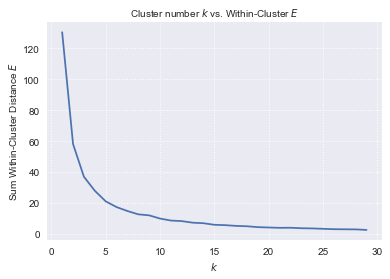

In [44]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.plot(K, sum_of_squared_distances)

# add axis legends
ax.set_xlabel("$k$", fontsize=10)
ax.set_ylabel("Sum Within-Cluster Distance $E$", fontsize=10)

# add plot title
plt.title('Cluster number $k$ vs. Within-Cluster $E$', fontsize=10);

### Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Apply k-Means clustering to all four features contained in the Iris dataset.**

> Use the k-Means classifier to learn a model of all four features contained in the Iris dataset, namely `Sepal length (cm)`, `Sepal width (cm)`, `Petal length (cm)` and `Petal width (cm)`.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Determine the optimal number of cluster values $k$ of all four features contained in the iris dataset.**

> Determine the optimal number of clusters $k$ needed to cluster the observations of all four features contained in the iris dataset using the **'elbow'** technique outlined above.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

### Lab Summary:

In this fourth lab, a step by step introduction into the unsupervised **k-Means Clustering** machine learning algorithm was presented. The code and exercises presented in this lab may serve as a starting point for more complex and tailored programs.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [2]:
# installing the nbconvert library
!pip install nbconvert
!pip install jupyter_contrib_nbextensions

/bin/sh: pip: command not found
/bin/sh: pip: command not found


Let's now convert the Jupyter notebook into a plain Python script:

In [3]:
!jupyter nbconvert --to script cfds_lab_05.ipynb

[NbConvertApp] Converting notebook cfds_lab_05.ipynb to script
[NbConvertApp] Writing 21028 bytes to cfds_lab_05.py
